<img src="../img/htw-logo.png" width=150>


**I758 Wissens- und KI-basierte Systeme**

# Lineare Regression mit Kreuzvalidierung
Quelle: Kaggle  / Anpassungen CK
 

<font color="green"><b>KLAUSURTAUGLICH.</b></font>
Dieses Notebook gehört zu den fünf Notebooks, die Sie für die Klausur einreichen können. Bei vollständiger und korrekter Bearbeitung **erhalten Sie Punkte für die Abgabe, die zu Ihrer Klausur addiert werden.**

<span style="color:#FF5F00"><b>AUFGABE:</b></span><br>

Auch dieses Notebook enthält wieder eine Reihe von neuen Bibliotheken. Legen Sie eine neue virtuelle Umgebung an oder erweitern Sie die bestehende `ml-class`. Studieren Sie dazu die Import-Anweisungen.


Tipp: Vermutlich wird Ihr Leben einfacher, wenn Sie eine `requirements.txt` anlegen. Mehr dazu finden Sie z.B. in [diesem Post von Stackoverflow](https://stackoverflow.com/questions/66899666/how-to-install-from-requirements-txt) 



### Cross-Validation with Linear Regression

This notebook demonstrates how to do feature selection and cross-validation (CV) with linear regression as an example (it is heavily used in almost all modelling techniques such as decision trees, SVM etc.). We will mainly use `sklearn` to do cross-validation.

In [132]:
# pip install scikit-learn

### Explore the data

Let us first load and prepare the data.

In [ ]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # suppress warnings
warnings.filterwarnings('ignore')

In [134]:
# import Housing.csv
housing = pd.read_csv('data/Housing.csv', sep=";")
housing.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,8012,394,1932,2018,1,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,9429,907,1928,1921,4,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,10410,413,1973,1943,1,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,7725,860,2005,1981,2,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,8316,266,1937,2018,2,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [135]:
# number of samples 
len(housing.index)

545

For the first experiment, we'll do regression with only one feature, `area`, and we'll build a model to predict the price. Let's filter the data so it only contains `area` and `price`.

<span style="color:#FF5F00"><b>AUFGABE 1:</b></span><br>
Reduzieren Sie den Data Frame.
</div>

Nutzen Sie die Pandas-Funktion `loc[ , ]`, um `housing` auf die Spalten `area` und `price` zu reduzieren. Speichern Sie das Ergebnis in `df`. Der Befehl `df.head()` sollte im Anschluss einen Output wie im Bild liefern.

<img src="./img/image_df_head.png">

In [ ]:
# filter only area and price
#* loc works as follows: [rows selection (condition), column selection]
df = housing.loc[:, ['area', 'price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


Scikit learn offers a wide variety of usefull *transformer* functions to scale, normalize and otherwise manipulate features.

<span style="color:#FF5F00"><b>AUFGABE 2:</b></span><br>

Skalieren Sie den Data Frame.
</div>

Nutzen Sie einen geeigneeten `Scaler`, um die beiden Spalten von `df` so zu skalieren, dass die Werte zwischen 0 und 1 liegen. Speichern Sie das Ergebnis in `df`. Der Befehl `df.head()` sollte im Anschluss einen Output wie im Bild liefern.

<img src="./img/image_df_scaler.png">

In [ ]:
# rescaling the variables (both)
df_columns = ['Scaled Area', 'Scaled Price']

scaler = MinMaxScaler((0, 1))
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns
df.head()

,Scaled Area,Scaled Price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


Let's plot the data to see the relationship between our single input feauture and the target variable.

<Axes: xlabel='Scaled Area', ylabel='Scaled Price'>

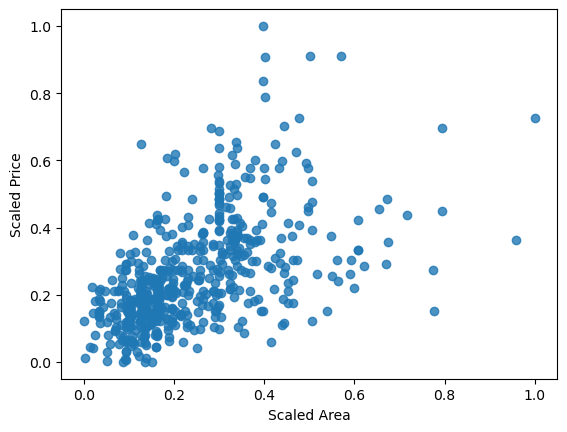

In [ ]:
# visualize area-price relationship
sns.regplot(x="Scaled Area", y="Scaled Price", data=df, fit_reg=False)

<span style="color:#FF5F00"><b>AUFGABE 3:</b></span><br>
Machen Sie sich klar, was Sie im Plot sehen. Was bedeuten die Werte an den Achsen? Was bedeutet die Verteilung der Punkte entlang x und y? Sieht man einen Zusammenhang zwischen x und y?
</div>

<span style="color:green"><b>Antwort zur AUFGABE 3:</b></span><br>

Da die Werte vorher skaliert wurden, zeigt das Diagramm die Verteilung von Werten jeweils zwischen dem minimalen (_skaliert auf 0_) und dem maximalen (_skaliert auf 1_) Werten. Die einzelne Datenpunkte werden somit relativ zu dem gesamten Wertebereich entlang entsprechenden Achsen plaziert. Ihre Positionen zeigen, wie nah oder fern die Proben vom Minimal- oder Maximalwerten liegen.

Aus dem Plot kann man einen groben linearen Zusammenhang zwischen `price` und `area` erkennen, der erstaunlicherweise mit steigenden Werten immer schwächer wird.

In [139]:
# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


### Experiments to Understand Overfitting

In this section, let's quickly go through some experiments to understand what overfitting looks like. We'll run some experiments using polynomial regression.

In [140]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['Scaled Area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['Scaled Price']

X_test = df_test['Scaled Area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['Scaled Price']

### Polynomial Regression

You already know simple linear regression:

$y = \beta_0 + \beta_1 x_1$

In polynomial regression of degree $n$, we fit a curve of the form:

$y = \beta_0 + \beta_1 x_1 + \beta_2x_1^2 + \beta_3x_1^3 ... + \beta_nx_1^n$

In the experiment below, we have fitted polynomials of various degrees on the housing data and compared their performance on train and test sets.

In sklearn, polynomial features can be generated using the `PolynomialFeatures` class. Also, to perform `LinearRegression` and `PolynomialFeatures` in tandem, we will use the module `sklearn_pipeline` - it basically creates the features and feeds the output to the model (in that sequence).

<span style="color:#FF5F00"><b>AUFGABE 4:</b></span><br>
Wann ist der Einsatz einer polynomialen Regression sinnvoll, welche Vor- und Nachteile ergeben sich daraus im Vergleich zu einer einfachen linearen Regression?
</div>

<span style="color:green"><b>Antwort zur AUFGABE 4:</b></span><br>

Polynomiale Regression dient dazu, nicht-lineare (_"kurvenförmige"_) Zusammenhänge auf eine einfachen Weise anzunähern. Besonders vorteilshaft ist diese Art von Regression bei Analyse von Funktionen mit einer Variable und niedrigem Potenzgrad. Wenn es mehrere Variablen gibt oder der Potenzgrad zu hoch ist, besteht das Risiko entweder vom extrem hohen Rechenaufwand oder von Überanpassung an das Train Dataset.

In [141]:
len(X_train)

381

Let's now predict the y labels (for both train and test sets) and store the predictions in a table. Each row of the table is one data point, each column is a value of $n$ (degree).

<table style="width:100%">
  <tr>
    <th>   </th>
    <th>degree-1</th>
    <th>degree-2</th> 
    <th>degree-3</th>
    <th>...</th>
    <th>degree-n</th>
  </tr>
  <tr>
    <th>x1</th>
  </tr>
  <tr>
    <th>x2</th>
  </tr>
   <tr>
    <th>x3</th>
    </tr>
    <tr>
    <th>...</th>
    </tr>
    <tr>
    <th>xn</th>
    </tr>
</table>

In [142]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
    

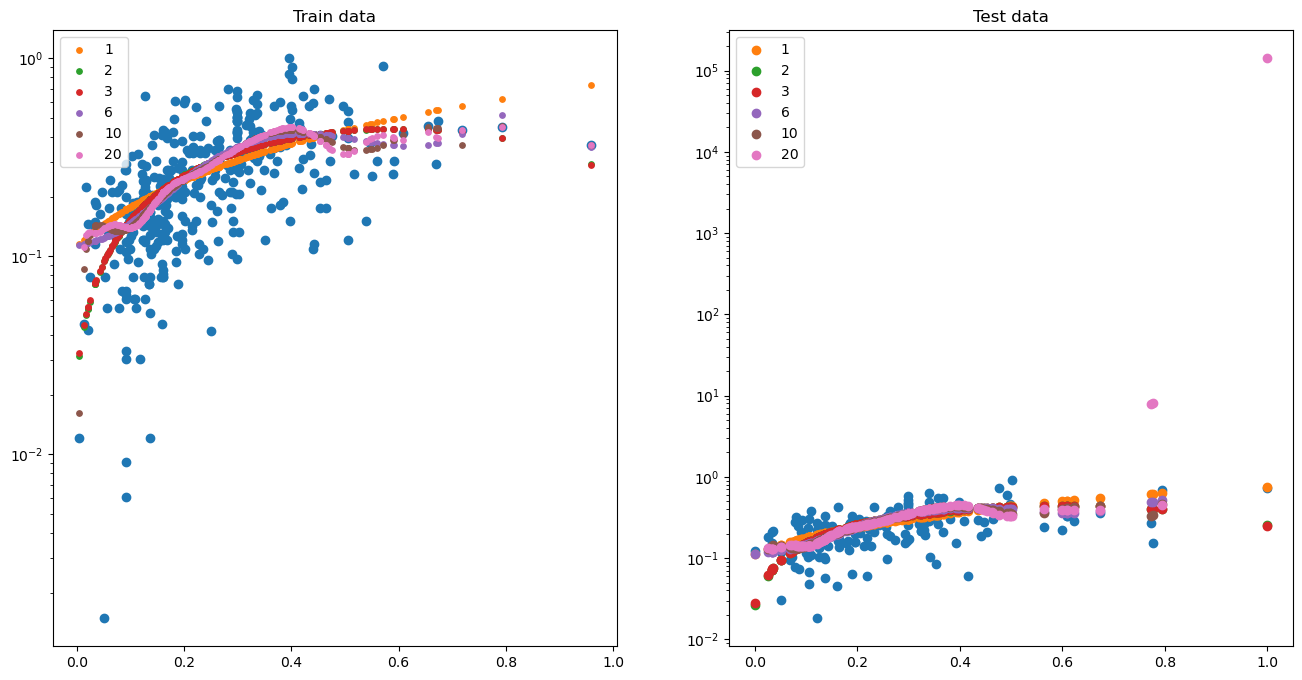

In [ ]:
# visualize train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

<span style="color:#FF5F00"><b>AUFGABE 5:</b></span><br>
Machen Sie sich klar, was Sie in den Plots sehen. Notieren Sie im Feld unten Ihre Beobachtungen.
<ul>
<li>Frage 1: In welchem Zusammenhang stehen die bunten Linien zu den blauen Punkten?</li>
<li>Frage 2: Was bedeuten die verschiedenen Farben der Linien?</li>
<li>Frage 3: Können Sie aus den Linien (im Feld "Test") irgendetwas sehen zu der Frage, welches Modell das "Beste" sein könnte?</li>
</ul>
</div>

<span style="color:green"><b>Antwort zur AUFGABE 5:</b></span><br>

- Antwort 1: Die bunten Linien zeigen jeweils eine Regression mit entsprechendem Potenzgrad. Diese repräsentieren eine Annäherungsfunktion, die aus den blauen Punkten modeliert wurde.
- Antwort 2: Die Farbe ist zur Unterscheidung zwischen Regressionnen verwendet, damit sie alle auf einem Diagramm gezeichnet werden können.
- Antwort 3: Aus dem Test-Plot kann man grob abschätzen, dass die Regressionen mit niedrigen Potenzgraden (_1, 2, 3_) allgemein nicht schlimmer als die mit hohen (_6, 10, 20_) sind. Besonders auffällig sind die Regression mit dem Grad 3 (_die anscheinend die genaueste ist_) und die mit dem Grad 20 (_die einen plötzlichen Ausreißer bei_ `x = 0.8` _hat_).

Let us now evaluate the quality of our predictions by comparing predictions to true values. We use the R2 statistic for that.

In [144]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-5611790645.97


<span style="color:#FF5F00"><b>AUFGABE 6:</b></span><br>

Schauen Sie sich die Zahlen mit den R squared values in Ruhe an. Bemerken Sie das absurde Verhalten?  

Was fällt Ihnen beim Vergleich der R-Squared-Werte der polynomialen Regression bei unterschiedlichen Graden auf, insbesondere bei Grad 10 und 20, und wie lässt sich dieses Verhalten im Hinblick auf Overfitting, negatives R² und die Generalisierungsfähigkeit des Modells erklären? Welche Grade erscheinen sinnvoll und welche führen zu instabilem, realitätsfernem Modellverhalten?
</div>

<span style="color:green"><b>Antwort zur AUFGABE 6:</b></span><br>

Aus den ausgegebenen Bewertungen ist es sofort klar, dass die höchsten Potenzgrade von 10 und 20 extrem ungenau sind.

Da die $R^2$ Score (_von mindestens $-\infty$ bis höchstens 1_) als die Generalisierungsfähigkeit von Regressionsmodellen interpretiert werden kann, kann man zusätzlich schlussfolgern, dass höhere Grade tendenziell zu Überanpassung führen und somit die Genauigkeit von einem Modell auf Test Datasets verhindern. Gleichzeitig zeigen die niedrigen Grade 1, 2 und 3 die besten Ergebnisse.

### 1. Building a Model Without Cross-Validation

Let's now build a multiple regression model. First, let's build a vanilla MLR model without any cross-validation etc. 

In [145]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,8012,394,1932,2018,1,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,9429,907,1928,1921,4,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,10410,413,1973,1943,1,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,7725,860,2005,1981,2,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,8316,266,1937,2018,2,4,1,2,1,1,1,0,1,2,0,furnished


In [146]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


In [147]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis = 1)
housing.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,8012,394,1932,2018,1,4,2,3,1,0,0,0,1,2,1,furnished,False,False
1,12250000,8960,9429,907,1928,1921,4,4,4,4,1,0,0,0,1,3,0,furnished,False,False
2,12250000,9960,10410,413,1973,1943,1,3,2,2,1,0,1,0,0,2,1,semi-furnished,True,False
3,12215000,7500,7725,860,2005,1981,2,4,2,2,1,0,1,0,1,3,1,furnished,False,False
4,11410000,7420,8316,266,1937,2018,2,4,1,2,1,1,1,0,1,2,0,furnished,False,False


In [148]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,8012,394,1932,2018,1,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,9429,907,1928,1921,4,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,10410,413,1973,1943,1,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,7725,860,2005,1981,2,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,8316,266,1937,2018,2,4,1,2,1,1,1,0,1,2,0,False,False


#### Splitting Into Train and Test

<span style="color:#FF5F00"><b>AUFGABE 7:</b></span><br>

Das können Sie schon: erstellen Sie aus `housing` Test- und Trainingsdaten (70% Train, 30% Test).  Skalieren Sie anschließend alle numerischen Werte in Train mit einem `MinMaxScaler`!
</div>

In [149]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, train_size=0.7, test_size=0.3)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
12,0.654545,0.351254,7216,559,1982,2013,3,0.6,0.333333,0.333333,1,0,0,0,1,0.333333,1,True,False
338,0.184848,0.152688,4431,63,1966,2005,4,0.2,0.000000,0.333333,1,1,1,0,0,0.000000,0,True,False
403,0.151515,0.809606,13009,105,1998,2007,5,0.4,0.000000,0.000000,1,0,0,0,0,0.000000,0,False,True
449,0.121212,0.000000,1668,709,1970,1982,5,0.4,0.000000,0.333333,0,0,1,0,0,0.000000,0,False,True
81,0.421212,0.168459,4269,341,1925,1941,2,0.4,0.333333,0.333333,1,0,1,0,1,0.333333,0,True,False


<span style="color:#FF5F00"><b>AUFGABE 8:</b></span><br>

Das können Sie auch schon: Übertragen Sie nun die Daten auf das Test-Set!
</div>

In [150]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,garea,immo_score,build,ren,n_occ,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
457,0.130000,0.073684,3398,455,1972,1966,3,0.25,0.0,0.000000,0,0,0,0,1,0.000000,0,False,True
358,0.190000,0.107368,3933,105,1977,1976,3,0.00,0.0,0.000000,1,0,0,0,0,0.000000,1,True,False
526,0.053333,0.086316,3531,520,1998,1969,4,0.00,0.0,0.000000,1,0,0,0,0,0.000000,0,False,True
398,0.166667,0.082105,3816,541,1975,1956,3,0.25,0.0,0.333333,1,0,0,0,0,0.333333,0,False,True
278,0.240667,0.101754,4192,623,1971,2012,3,0.25,0.0,0.333333,1,0,1,0,0,0.666667,1,True,False


In [151]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

Note that we haven't rescaled the test set yet, which we'll need to do later while making predictions.

#### Using RFE 

Now, we have 13 predictor features. To build the model using Recursive Feature Elemination (RFE), we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm. 

Note that the number of features to be used in the model is a **hyperparameter**.

In [152]:
# num of max features
len(X_train.columns)

18

In [153]:
# first model with an arbitrary choice of n_features
# running RFE with number of, let's say features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [154]:
# This block was modified for better output

# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
selection_list = list(zip(X_train.columns,rfe.support_,rfe.ranking_))

# sorting features by ranking
selection_list.sort(key=lambda x: x[2])
selection_list

[('area', np.True_, np.int64(1)),
 ('bedrooms', np.True_, np.int64(1)),
 ('bathrooms', np.True_, np.int64(1)),
 ('stories', np.True_, np.int64(1)),
 ('guestroom', np.True_, np.int64(1)),
 ('hotwaterheating', np.True_, np.int64(1)),
 ('airconditioning', np.True_, np.int64(1)),
 ('parking', np.True_, np.int64(1)),
 ('prefarea', np.True_, np.int64(1)),
 ('unfurnished', np.True_, np.int64(1)),
 ('mainroad', np.False_, np.int64(2)),
 ('basement', np.False_, np.int64(3)),
 ('semi-furnished', np.False_, np.int64(4)),
 ('n_occ', np.False_, np.int64(5)),
 ('build', np.False_, np.int64(6)),
 ('immo_score', np.False_, np.int64(7)),
 ('ren', np.False_, np.int64(8)),
 ('garea', np.False_, np.int64(9))]

In [155]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6608289791252291


<span style="color:#FF5F00"><b>AUFGABE 9:</b></span><br>

Halten Sie kurz inne und überlegen Sie, was Sie hier sehen. Halten Sie unten fest, welches Subset die RFE jetzt eigentlich ausgewählt hat.
</div>

<span style="color:green"><b>Antwort zur AUFGABE 9:</b></span><br>

Im Code oben hat man mit Recursive Feature Elimination acht Merkmale ausgeschlossen, sodass nur folgende geblieben sind:

- `area`
- `bathrooms`
- `stores`
- `mainroad`
- `basement`
- `hotwaterheating`
- `airconditioning`
- `parking`
- `prefarea`
- `unfurnished`

Anschließend hat man das Modell auch mit dem $R^2$ Score von 0.66 bewertet, was schon deutlich besser ist, als den Mittelwert von Datenpunkten zu raten.

In [156]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6391913791026904


<div class="alert alert-block alert-success">
<b>Arbeitsauftrag ohne Dokumentation</b> 
Wir haben jetzt also eine RFE mit n=6 und eine RFE mit n=10 gemacht. Welche ist besser?
</div>

## 2. Problems in the Current Approach

In train-test split, we have three options:
1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.


## 3. Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

![](https://chkra.github.io/wikisys_lecture/workshops/08/08/img/kfold_cross.png)

<span style="color:green">Since the image is unavailable here's one from `www.geeksforgeeks.org` with k=5:</span><br>
![](https://media.geeksforgeeks.org/wp-content/uploads/20250912171723027927/train_test_split.webp)

## 4. Cross-Validation in sklearn

Let's now experiment with k-fold CV.

### 4.1 K-Fold CV

In [157]:
# This code block was modified to output the mean of scores

# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)

print("Folds Scores:", scores)
print("Scores mean:", scores.mean())

Folds Scores: [0.58138325 0.69304942 0.62896516 0.64601075 0.62953309]
Scores mean: 0.6357883352149589


In [158]:
# This code block was modified to clarify the mean of scores

# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)

print("Folds Scores:", scores)
print("Scores mean:", scores.mean())

Folds Scores: [0.67156712 0.58348765 0.4993778  0.61314616 0.71352754]
Scores mean: 0.6162212542132938


<span style="color:#FF5F00"><b>AUFGABE 10:</b></span><br>

Sie sollten 5 Werte in der Variable scores sehen. Überlegen Sie kurz: was bedeuten diese Werte?
</div>

<span style="color:green"><b>Antwort zur AUFGABE 10:</b></span><br>

Da der gesamte Dataset für Cross Validation in fünf Folds aufgeteilt wurde und diese nachher mit  `cross_val_score()` bewertet wurden, bedeutet jede Zahl den $R^2$ Score von jeweiligem Fold.

Obwohl die einzelne Bewertungen sich deutlich um `0.03` bis `0.13` unterscheiden, sind die Mittelwerte trotzdem gleich geblieben.
Man kann also schlussfolgern, dass die implizite und explizite Definition vom Folding tatsächlich gleich sein kann.

In [159]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00902901, -0.00838021, -0.00837754, -0.00804446, -0.01240859])

### 4.2 Hyperparameter Tuning Using Grid Search Cross-Validation

A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called **grid search** cross-validation.
![](https://chkra.github.io/wikisys_lecture/workshops/08/08/img/hyperparam.png)

In [160]:
# number of features in X_train
len(X_train.columns)

18

In [161]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, len(X_train.columns)))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 17 candidates, totalling 85 fits


,estimator,RFE(estimator...rRegression())
,param_grid,"[{'n_features_to_select': [1, 2, ...]}]"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,fit_intercept,True


In [162]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.054817,0.041058,0.003694,0.000959,1,{'n_features_to_select': 1},0.296044,0.172977,-0.108864,0.257876,...,0.146265,0.142676,17,0.256227,0.279756,0.320562,0.274708,0.297835,0.285818,0.021851
1,0.029628,0.003357,0.003252,0.000250,2,{'n_features_to_select': 2},0.481819,0.424153,0.306652,0.469999,...,0.416309,0.062550,16,0.437740,0.452073,0.478037,0.449376,0.457715,0.454988,0.013238
2,0.026496,0.002008,0.003672,0.001304,3,{'n_features_to_select': 3},0.525934,0.470177,0.389886,0.532247,...,0.487156,0.053309,15,0.514552,0.524101,0.542248,0.517391,0.516438,0.522946,0.010174
3,0.033636,0.014427,0.003312,0.001074,4,{'n_features_to_select': 4},0.587076,0.506747,0.437973,0.485317,...,0.519490,0.057001,14,0.543121,0.563154,0.579218,0.570607,0.550241,0.561268,0.013144
4,0.029559,0.003072,0.004461,0.001464,5,{'n_features_to_select': 5},0.611660,0.469978,0.466539,0.447693,...,0.528822,0.083722,13,0.589919,0.611938,0.623564,0.579336,0.585300,0.598011,0.016868
5,0.022923,0.004094,0.003740,0.000553,6,{'n_features_to_select': 6},0.632561,0.526725,0.466391,0.503213,...,0.554065,0.070448,12,0.631732,0.648191,0.634829,0.617805,0.591064,0.624724,0.019405
6,0.027749,0.008749,0.003728,0.000975,7,{'n_features_to_select': 7},0.636865,0.533337,0.515023,0.499721,...,0.577547,0.078899,11,0.634489,0.650573,0.674491,0.623106,0.630413,0.642614,0.018303
7,0.020401,0.003277,0.004065,0.001107,8,{'n_features_to_select': 8},0.657256,0.570574,0.478628,0.609526,...,0.605139,0.078575,10,0.639495,0.655973,0.695197,0.652961,0.632167,0.655159,0.021829
8,0.021347,0.001057,0.004845,0.001096,9,{'n_features_to_select': 9},0.647896,0.578549,0.484799,0.606930,...,0.607455,0.077434,9,0.656799,0.665782,0.695969,0.665971,0.641922,0.665289,0.017664
9,0.017566,0.003624,0.003492,0.000857,10,{'n_features_to_select': 10},0.665626,0.583927,0.505093,0.596665,...,0.612036,0.070301,7,0.660225,0.675312,0.702166,0.675695,0.648236,0.672327,0.018097


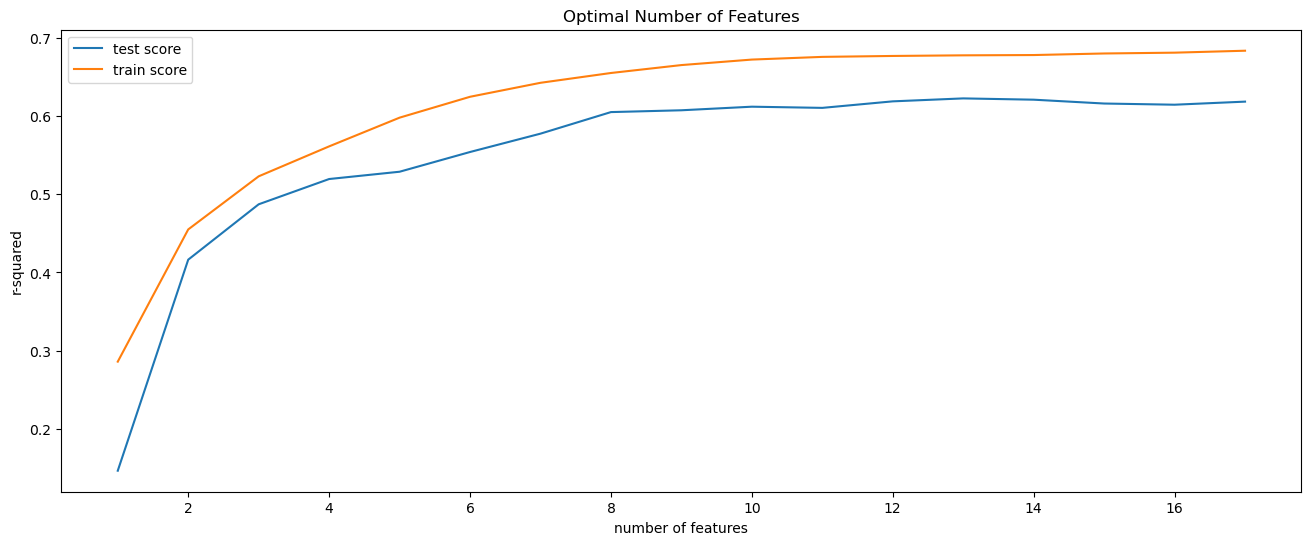

In [163]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

<span style="color:#FF5F00"><b>AUFGABE 11:</b></span><br>

Schauen Sie auf die Tabelle. Was ist das beste Ergebnis und in welcher Spalte / welcher Zeile sehen Sie das?
</div>

PS: Vielleicht hilft [dieser Link](https://stackoverflow.com/questions/54608088/what-is-gridsearch-cv-results-could-any-explain-all-the-things-in-that-i-e-me) ?

<span style="color:green"><b>Antwort zur AUFGABE 11:</b></span><br>  

In der Tabelle kann man anhand der `rank_test_score` Spalte gut erkennen, dass die Regressionen mit 12, 13 und 14 Merkmalen die drei besten sind. Nicht nur von einzelnen $R^2$ Test Scores in der Spalte `mean_test_score`(_von 0.619 bis 0.623_) sondern auch von der Standardabweichung in der Spalte `std_test_score` (_von 0.07 bis 0.074_) des jeweiligen Fold Scores sind diese drei Varianten die vernünftigste.

Now we can choose the optimal value of number of features and build a final model.

<span style="color:#FF5F00"><b>AUFGABE 12:</b></span><br>


Nutzen Sie den Wert aus der letzten Frage und korrigieren Sie bei Bedarf den Wert der Variable n_features_optimal.
</div>

In [171]:
# final model
#* I've chosen 13 optimal features because it's 
n_features_optimal = 13

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test

#? this original line doesn't make any sense with RFE usage, does it?
# y_pred = lm.predict(X_test)

#* the RFE should be used to predict instead
y_pred = rfe.predict(X_test)

r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6809173961614092


Notice that the test score is very close to the 'mean test score' on the k-folds (about 60%). In general, the mean score estimated by CV will usually be a good estimate of the test score. 

### 4.3 Types of Cross-Validation Schemes


1. **K-Fold** cross-validation: Most common
2. **Leave One Out (LOO)**: Takes each data point as the 'test sample' once, and trains the model on the rest n-1 data points. Thus, it trains n total models.
    - Advantage: Utilises the data well since each model is trained on n-1 samples
    - Disadvantage: Computationally expensive
3. **Leave P-Out (LPO)**: Creat all possible splits after leaving p samples out. For n data points, there are (nCp) possibile train-test splits.
4. (**For classification problems**) **Stratified K-Fold**: Ensures that the relative class proportion is approximately preserved in each train and validation fold. Important when ther eis huge class imbalance (e.g. 98% good customers, 2% bad).

#### Additional Reading ####
The sklearn documentation enlists all CV schemes <a href="http://scikit-learn.org/stable/modules/cross_validation.html">here.</a>
